In [58]:
import tensorflow as tf
#from tensorflow.contrib.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout
import numpy as np
import pandas as pd
import copy
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost

In [2]:
columns=['building','barren_land','trees','grassland','road','water']

x_train = pd.read_csv(tf.gfile.Open('data/X_train_sat6.csv'),header=None) #This will kill the available memory on the kaggle machine :\
y_train = pd.read_csv(tf.gfile.Open('data/y_train_sat6.csv'),names=columns)
#y_train['y'] = y_train.idxmax(axis=1)
x_train = x_train.values.reshape(x_train.shape[0],28,28,4).astype(np.float32)
#y_train = y_train.values.astype(np.float32)

x_test = pd.read_csv(tf.gfile.Open('data/X_test_sat6.csv'),header=None)
y_test = pd.read_csv(tf.gfile.Open('data/y_test_sat6.csv'),names=columns)
y_test['y'] = y_test.idxmax(axis=1)
x_test = x_test.values.reshape(x_test.shape[0],28,28,4).astype(np.float32)
#y_test = y_test.values.astype(np.float32)

print("All files loaded")

All files loaded


In [3]:
y_train.head()

,building,barren_land,trees,grassland,road,water
0,0,0,1,0,0,0
1,0,1,0,0,0,0
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,0,0,1


In [4]:
y_ints = [y.argmax() for y in y_train.values]

In [5]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_ints),
                                                 y_ints)

In [6]:
class_weights

array([3.61857535, 0.73572489, 0.95055361, 1.07255646, 6.59179688,
       0.44875843])

<bound method ResourceVariable.value of <tf.Variable 'Adam_4/lr:0' shape=() dtype=float32>>

In [22]:
def train_model(params, optimizer='atom'):

    model = tf.keras.Sequential()

    # 1 convolutional layer - 32 filters, 5x5 kernel_size, padding=same, activation=relu
    model.add(tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(28, 28, 4)))

    # 2 maxpool layer - pool_size=2x2, strides=2
    model.add(tf.keras.layers.MaxPooling2D(strides=2))

    # 3 convolutional layer - 64 filters, 5x5 kernel_size, padding=same, activation=relu
    model.add(tf.keras.layers.Conv2D(64, (5,5), padding='same', activation='relu'))

    # 4 maxpool layer - pool_size=2x2, strides=2
    model.add(tf.keras.layers.MaxPooling2D(strides=2))

    # 5 flatten layer 4 output
    model.add(tf.keras.layers.Flatten())

    # 6 fully connected layer - 1024 units, relu activation
    model.add(tf.keras.layers.Dense(1024, activation='relu'))

    # 7 dropout layer
    model.add(tf.keras.layers.Dropout(rate=0.5))

    # 8 fully connected layer - 256 units, relu activation
    model.add(tf.keras.layers.Dense(256, activation='relu'))

    # 9 fully connected layer - 6 units, (softmax activation)
    model.add(tf.keras.layers.Dense(6, activation='softmax'))

    # configure optimizer
    if optimizer == 'atom':
        
        atom = tf.keras.optimizers.Adam(params['lr'], beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
        
    elif optimizer == 'sgd':
        
        sgd = tf.keras.optimizers.SGD(params['lr'], momentum=0.9, nesterov=True)

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer=atom, metrics=['accuracy'])
    
    # fit model
    model.fit(x_train, y_train, batch_size=32, epochs=10)
    
    # save model
    title = 'baseline_model_'+optimizer+'_'+str(params['lr'])
    model.save(title+'.h5')
    
    return model

In [40]:
def load_model(filename):
    """Returns tuple of model object and filename"""
    return tf.keras.models.load_model(filename), filename

In [44]:
def evaluate_cnn(model, params=None, filename=None):
    # evaluate model
    score = model.evaluate(x_test, y_test.loc[:,'building':'water'], batch_size=32)
    print("Model accuracy = "+str(score[1]))
    
    actuals = y_test.y
    cnn_preds = model.predict(x_test)
    
    
    cnn_preds_df = pd.DataFrame(cnn_preds, columns=columns)
    cnn_preds_df['y'] = cnn_preds_df.idxmax(axis=1)
    
    
    # Generate confusion matrix
    
    fig, ax = plt.subplots(figsize=(15, 12))
    
    Z = confusion_matrix(actuals, cnn_preds_df.y)
    # Normalize across predictions
    norm_Z = normalize(Z, axis=1)

    # Generate heatmap
    sns.heatmap(norm_Z, cmap=plt.cm.nipy_spectral, annot=True, cbar=True, xticklabels=columns, yticklabels=columns)

    ## Format axes object
    ax.xaxis.set_ticks_position('top') 
    ax.xaxis.set_label_position('top')
    #  Format X-axis label and ticks
    plt.xticks(fontsize=12)
    plt.xlabel('Predicted', fontdict={'size': 18})

    # Format Y-axis label
    plt.yticks(rotation=0, fontsize=12)
    plt.ylabel('Actual', rotation=0, fontdict={'size': 18})
    
    # Format Title
    if params:
        sub_title = ""
        for key in params.keys():
            if params[key]:
                sub_title+=str(params[key])+'_'
        print(sub_title)
    
    if filename:
        sub_title = filename
    ax.set_title(f'6 Landcover Classes – {sub_title}\n\n\n', fontdict={'size': 18, 'weight': 'bold'});
    fig.savefig(f'6 Landcover Classes – {sub_title}\n\n\n', bbox_inches='tight', dpi=300)
    

In [60]:
def get_feature_layer(model, data):
    
    total_layers = len(model.layers)
    
    # 0-indexed, feature layer is 1 before end
    fl_index = total_layers-2
    
    feature_layer_model = tf.keras.Model(inputs=model.input,
                                outputs=model.get_layer(index=fl_index).output)
    feature_layer_output = feature_layer_model.predict(data)
    
    return feature_layer_output

In [61]:
def train_xgboost(x_train, y_train):
    
    # load trained cnn
    cnn = load_model("baseline_model_atom_5.5e-5.h5")
    
    # get feature layer train data
    fl_out = get_feature_layer(cnn, x_train)
    
    # instantiate xgb
    xgb_model = xgboost.XGBClassifier(silent=False,
                                learning_rate=0.1, 
                                max_depth=6,objective='multi:softmax', 
                                n_estimators=175)

    
    xgb_model.fit(fl_out, y_train)

    return xgb_model

In [ ]:
def eval_cnn_xgb(xgb_model, x_test, y_test):

    # load trained cnn
    cnn = load_model("baseline_model_atom_5.5e-5.h5")

    # get feature layer test data
    fl_out = get_feature_layer(cnn, x_train)
    
    score = xgb_model.score(fl_out, y_test)
    
    print('xgb score = '+str(score))
    
    return xgb_model
    

In [62]:
xgb = train_xgboost(x_train, y_train)

AttributeError: 'tuple' object has no attribute 'layers'

81000/81000 [==============================] - 12s 147us/step
Model accuracy = 0.9936049382716049


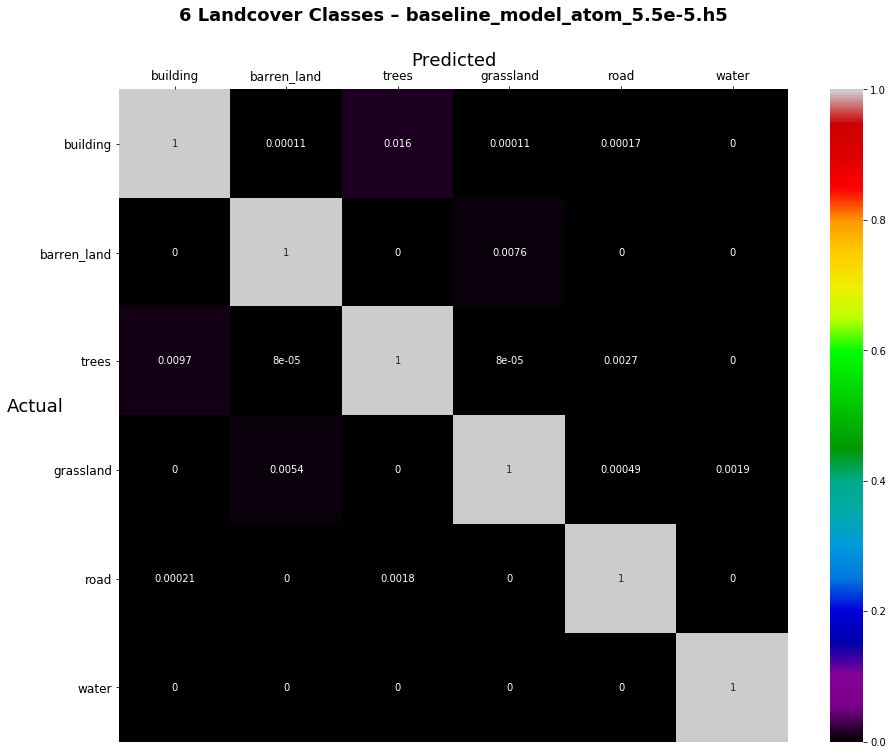

In [45]:
evaluate_model(model=best[0], filename=best[1])

In [55]:
len(model.layers)

9

In [57]:
model.layers[]

IndexError: list index out of range

unweighted scores

sdg

[0.048675902403128996, 0.9827654320987654]

atom 1e-5

[0.03177257826200788, 0.9895308641975309]

atom 1e-6

[0.06629317183666403, 0.9753950617283951]

atom 5e-6

[0.04309150624197965, 0.9848888888888889]

atom 5e-5

[0.027689415797445018, 0.9914691358024691]

atom 5e-5 ams

[0.02677221671924655, 0.990358024691358]

atom 7.5e-5

(stuck at .54)

atom 7e-5

(stuck at .54)

atom 6e-5

[0.035970908765554074, 0.9880740740740741]

atom 5.5e-5

[0.019541240541552478, 0.9936049382716049]

atom 5.3e-5

[0.028512682099493404, 0.9908271604938271]

atom 5.7e-5

[0.024852997347159324, 0.9914320987654321]

atom 5.6e-5

(converges at .59)

atom 5.5e-4 v2

[0.02222598712769814, 0.9926296296296296]
